# Final Notebook

## Business Understanding 

Our stakeholder is a real-estate company who are looking to expand to King County, Seattle starting from 2016. They need a reliable prediction metric for house prices and would like to know which features of houses are more important. Our task is to provide them with a linear regression model that will provide them with an equation which will include features that are most important in determining housing prices. With our model, they can predict the prices of other houses in the region  that will be available in the upcoming years. 

## Data Understanding 

Import necessary modules for analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
from matplotlib.lines import Line2D
warnings.filterwarnings('ignore')

Import dataset

In [2]:
df = pd.read_csv('../data/kc_house_data.csv')

Let's look at some properties of the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Data Preparation

It appears that `waterfront`,`view` and `yr_renovated` columns have some missing values. Let's resolve those issues.

In [4]:
df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

Less than 1% of listed homes have a waterfront access, so these seem like infrequent enough cases that we will fill missing values with "NO".

In [5]:
df['waterfront'].fillna("NO",inplace=True)

In [6]:
df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

More than 90% of listed homes have no view, so we will use the mode to fill the missing values.

In [7]:
df['view'].fillna("NONE",inplace=True)

In [8]:
df['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

Very few homes from this list have been renovated.  The 0 values may have never been renovated, but we can't know that for sure.  Since there are so many 0s and also many missing entries, we decided that the column itself should be dropped.

In [9]:
df.drop('yr_renovated', axis=1,inplace=True)

Finally, let's look at the `date` column with type `object`. 

In [10]:
df['date'].value_counts()

6/23/2014     142
6/25/2014     131
6/26/2014     131
7/8/2014      127
4/27/2015     126
             ... 
3/8/2015        1
2/15/2015       1
1/31/2015       1
1/10/2015       1
11/30/2014      1
Name: date, Length: 372, dtype: int64

`date` column includes the date each house was sold. Since this data won't be available in actual test sets since those houses don't have a sale date yet, we decided that the column itself should be dropped as it will be useless in predicting sale prices of houses that aren't sold yet.

In [11]:
df.drop('date', axis=1,inplace=True)

Upon investigation, it was observed that there is only one house that has a `grade` of `3 Poor`. So, when samples will be split into training and test sets, one gets it, the other does not.  This results is mismatched columns/rows at the end of the process, so we decided to drop that observation.

In [12]:
df['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [13]:
df = df[df['grade'] != "3 Poor"]

### Train/Test Split

It is time to split the data into training and test sets. This way, we can train our model using the training set and use the test set to see how successful our model is. 

In [14]:
y = df['price']
X = df.drop('price',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69)

## Feature Engineering

`sqft_basement` column is also of type `object`. Let's convert that to a number type as well.

In [15]:
X_train['sqft_basement'].value_counts()

0.0       9634
?          354
700.0      166
600.0      164
500.0      152
          ... 
207.0        1
1852.0       1
2610.0       1
143.0        1
374.0        1
Name: sqft_basement, Length: 280, dtype: int64

There are many 0 values, which likely means no basement. We'll  assume that the `?` values have no basements as well, so we'll fill them with 0.

In [16]:
X_train['sqft_basement'].replace('?','0.0',inplace=True)
X_train['sqft_basement'] = pd.to_numeric(X_train['sqft_basement'], errors = 'coerce')

### Outlier Elimination

We should get rid of outliers as they are not a part of the general trend of our dataset. 

In [17]:
train = pd.concat([X_train, y_train], axis=1)

In [18]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','yr_built','sqft_living15',
'sqft_lot15']
for i in features:
    train = train[(np.abs(stats.zscore(train[i])) < 3)]
y_train = train['price']
X_train = train.drop('price',axis=1)

Outlier elimination gets rid of all mansions in the train set, so we decided to get rid of mansions in the test set as we won't be able to provide predictions for those houses if they are none in our training set. 

In [19]:
temp_test = pd.concat([X_test, y_test], axis=1)
temp_test = temp_test[temp_test['grade'] != "13 Mansion"]
y_test = temp_test['price']
X_test = temp_test.drop('price',axis=1)

### Feature Scaling

Feature scaling allows us to bring all continous features to the same scale, which will help with comparing the effects of each feature on the model. 

In [20]:
features_to_scale=['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','yr_built','zipcode','lat','long',
'sqft_lot15']
features_not_to_scale = ['id', 'bedrooms', 'bathrooms','floors', 'waterfront', 'view', 'condition', 'grade']
scale = X_train[features_to_scale]
no_scale = X_train[features_not_to_scale]

In [21]:
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(scale)
scaled_X_train = pd.DataFrame(data=X_train_scaled, columns=scale.columns, index=scale.index)

In [22]:
X_train = pd.concat([scaled_X_train, no_scale],axis=1)

### Encoding Categorical Variables

#### Waterfront

In [23]:
X_train['waterfront'].value_counts()

NO     14936
YES       74
Name: waterfront, dtype: int64

`waterfront` is a categorical variable with two categories. Therefore, we will use the `OrdinalEncoder` to encode it.

In [24]:
waterfront_train = X_train[['waterfront']]
encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]
waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()
X_train['waterfront'] = waterfront_encoded_train

#### View

In [25]:
X_train['view'].value_counts()

NONE         13769
AVERAGE        596
GOOD           273
FAIR           207
EXCELLENT      165
Name: view, dtype: int64

`view` is a categorical variable with multiple categories. Therefore, we will use the `OneHotEncoder` to encode it.

In [26]:
view_train = X_train[['view']]
ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")
ohe.fit(view_train)
view_encoded_train = ohe.transform(view_train)
view_encoded_train = pd.DataFrame(view_encoded_train, columns=ohe.categories_[0], index=X_train.index)
X_train.drop("view", axis=1, inplace=True)
X_train = pd.concat([X_train, view_encoded_train],axis=1)

#### Condition

In [27]:
X_train['condition'].value_counts()

Average      9668
Good         3994
Very Good    1208
Fair          118
Poor           22
Name: condition, dtype: int64

`condition` is also a categorical variable with multiple categories. Therefore, we will use the `OneHotEncoder` to encode it.

In [28]:
condition_train = X_train[['condition']]
ohe.fit(condition_train)
condition_encoded_train = ohe.transform(condition_train)
condition_encoded_train = pd.DataFrame(condition_encoded_train, columns=ohe.categories_[0],index=X_train.index)
X_train.drop('condition', axis=1, inplace=True)
X_train = pd.concat([X_train, condition_encoded_train], axis=1)

#### Grade

In [29]:
X_train['grade'].value_counts()

7 Average        6517
8 Good           4332
9 Better         1754
6 Low Average    1491
10 Very Good      632
5 Fair            177
11 Excellent       85
4 Low              17
12 Luxury           5
Name: grade, dtype: int64

`grade` is also a categorical variable with multiple categories. Therefore, we will use the `OneHotEncoder` to encode it.

In [30]:
grade_train = X_train[['grade']]
ohe.fit(grade_train)
grade_encoded_train = ohe.transform(grade_train)
grade_encoded_train = pd.DataFrame(grade_encoded_train, columns=ohe.categories_[0], index=X_train.index)
X_train.drop("grade", axis=1, inplace=True)
X_train = pd.concat([X_train, grade_encoded_train], axis=1)

Finally, now that we encoded all categorical columns, let's rename those columns for better readability.

In [31]:
column_names = {
    "AVERAGE" : "View_Avg",
    "EXCELLENT" : "View_Exc",
    "FAIR" : "View_Fair",
    "GOOD" : "View_Good",
    "NONE" : "View_NONE",
    "Average" : "Cond_Avg",
    "Fair" : "Cond_Fair",
    "Good" : "Cond_Good",
    "Poor" : "Cond_Poor",
    "Very Good" : "Cond_VGood",
    "10 Very Good" :  "Grade_VGood",
    "11 Excellent" :  "Grade_Exc",
    "12 Luxury" : "Grade_Lux",
    "4 Low" : "Grade_Low",
    "5 Fair" : "Grade_Fair",
    "6 Low Average" : "Grade_LAvg",
    "7 Average" : "Grade_Avg",
    "8 Good" : "Grade_Good",
    "9 Better" : "Grade_Better",    
}

In [32]:
X_train.rename(column_names, axis=1,inplace=True)

### Assumptions of Linear Regression

In order to run linear regression, there are some conditions we need to check for.

#### Linear Relationship

There should be a linear relationship between independent and dependent variables. This can be checked by using scatterplots and looking at correlations.

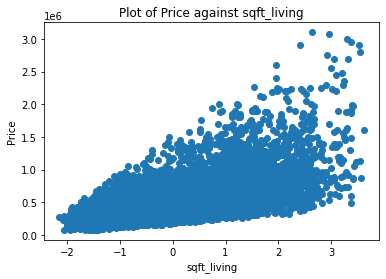

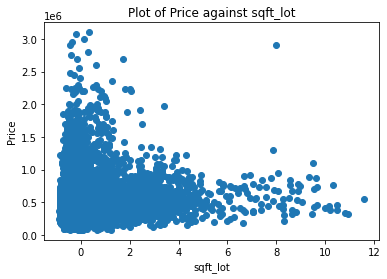

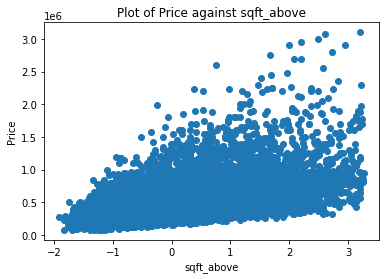

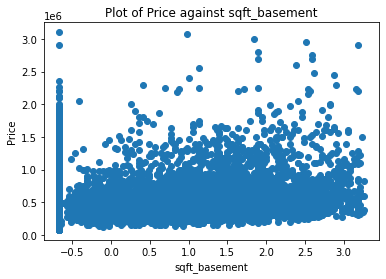

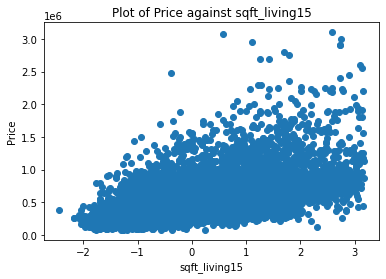

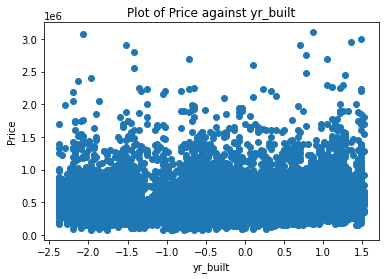

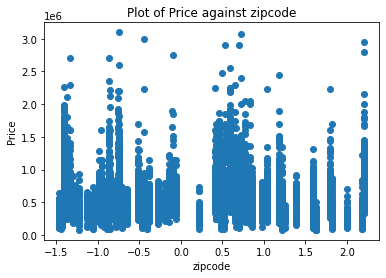

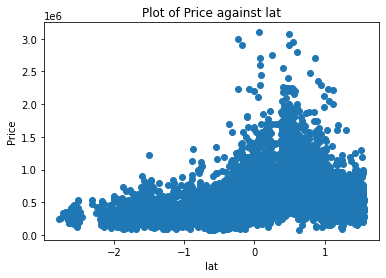

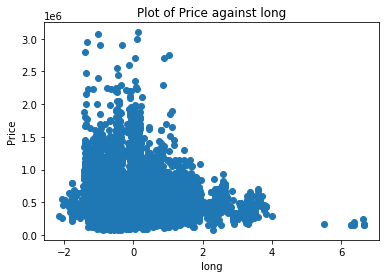

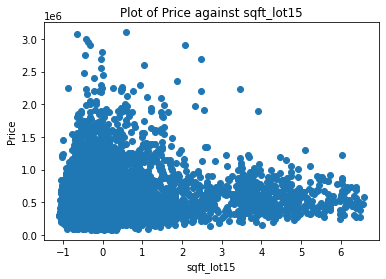

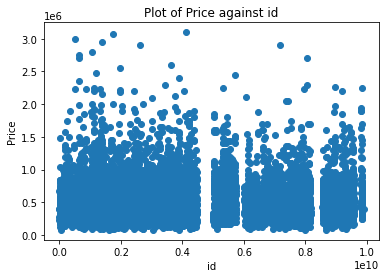

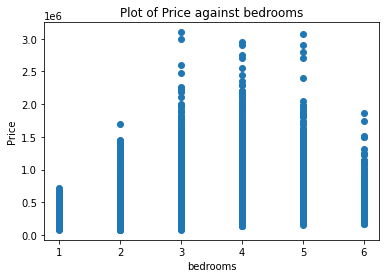

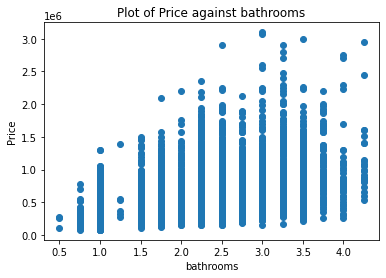

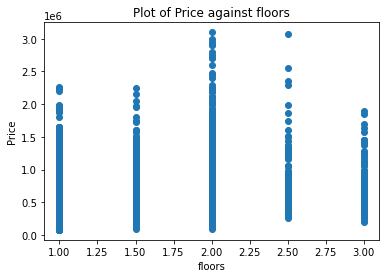

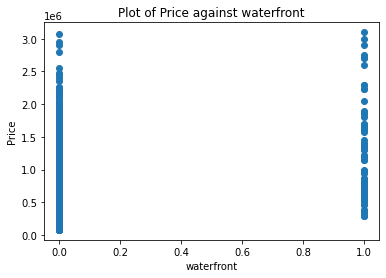

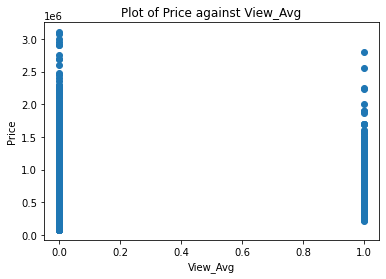

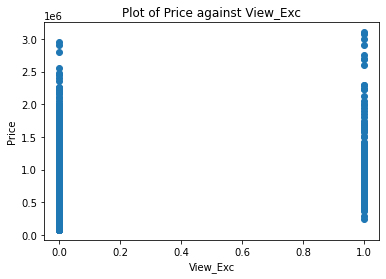

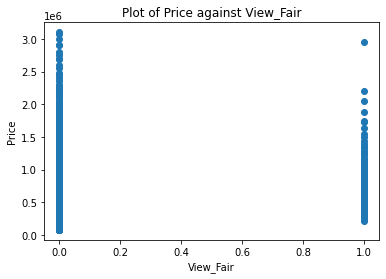

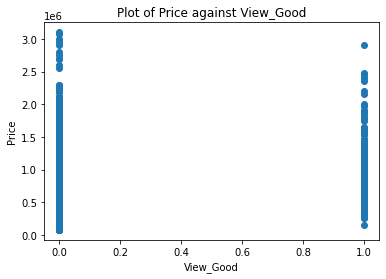

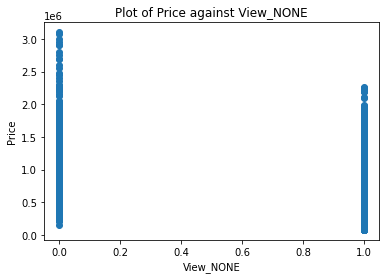

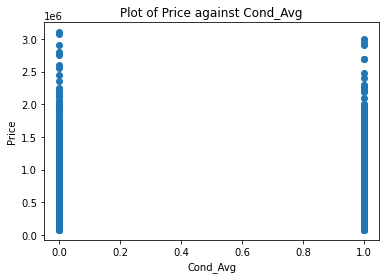

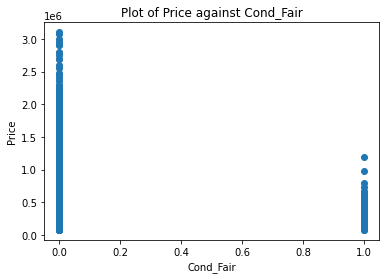

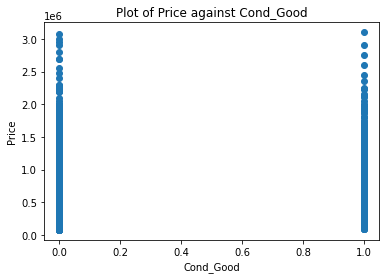

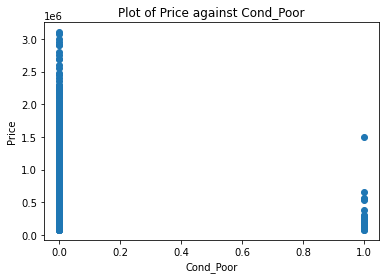

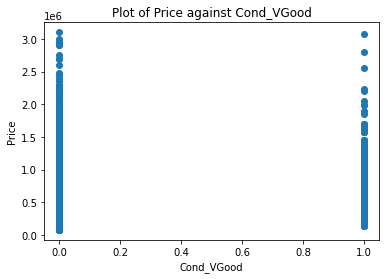

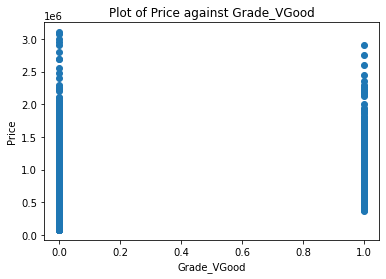

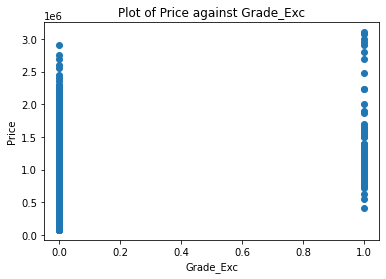

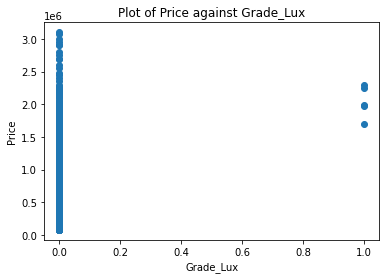

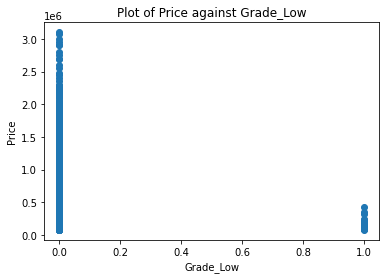

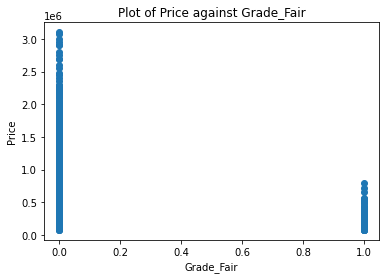

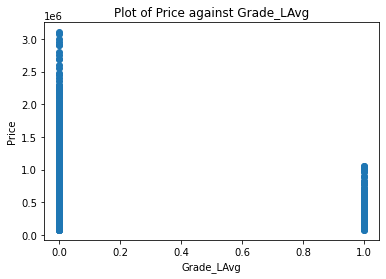

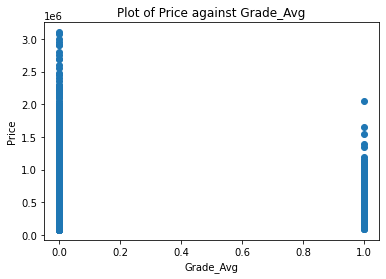

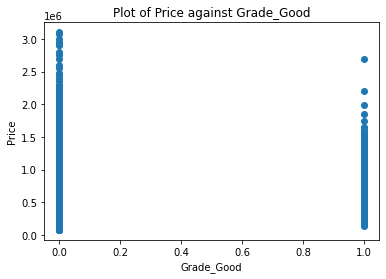

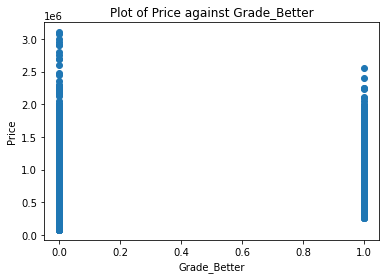

In [33]:
for x in X_train.columns:
    plt.scatter(X_train[x], y_train)
    plt.title(f'Plot of Price against {x}')
    plt.xlabel(x)
    plt.ylabel('Price')
    plt.show()

It appears that `sqft_living`,`sqft_above`, `sqft_living15` and `bathrooms` columns have a somewhat linear relationship with `price`.

Next, let's check correlations of independent (predictor) variables with the dependent (target) variable from highest to lowest:

In [34]:
temp = pd.concat([X_train, y_train], axis=1)
temp.corr().abs()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.619902
sqft_living15    0.544502
sqft_above       0.514286
bathrooms        0.437250
lat              0.375590
Grade_VGood      0.365916
Grade_Better     0.340201
View_NONE        0.336194
Grade_Avg        0.317161
bedrooms         0.279526
floors           0.268613
sqft_basement    0.255543
View_Exc         0.247405
Grade_LAvg       0.242305
Grade_Exc        0.222430
waterfront       0.197582
View_Good        0.188595
View_Avg         0.156325
Grade_Lux        0.102109
Grade_Fair       0.099903
View_Fair        0.094856
Grade_Good       0.089122
sqft_lot15       0.086348
sqft_lot         0.083438
Cond_VGood       0.069397
Cond_Fair        0.060494
Grade_Low        0.037220
Cond_Poor        0.024515
Cond_Good        0.017844
id               0.011816
long             0.010514
Cond_Avg         0.009843
zipcode          0.005208
yr_built         0.001023
Name: price, dtype: float64

The table above agrees with the linearity observations from the scatterplot. The highest four correlations are `sqft_living`, `sqft_above`, `bathrooms` and `sqft_living15`.

#### Low Multicollinearity

In linear regression models, independent (predictor) variables shouldn't be highly correlated with each other . This can be checked by looking at the correlations. Let's do that by generating a heatmap to view these correlations visually.

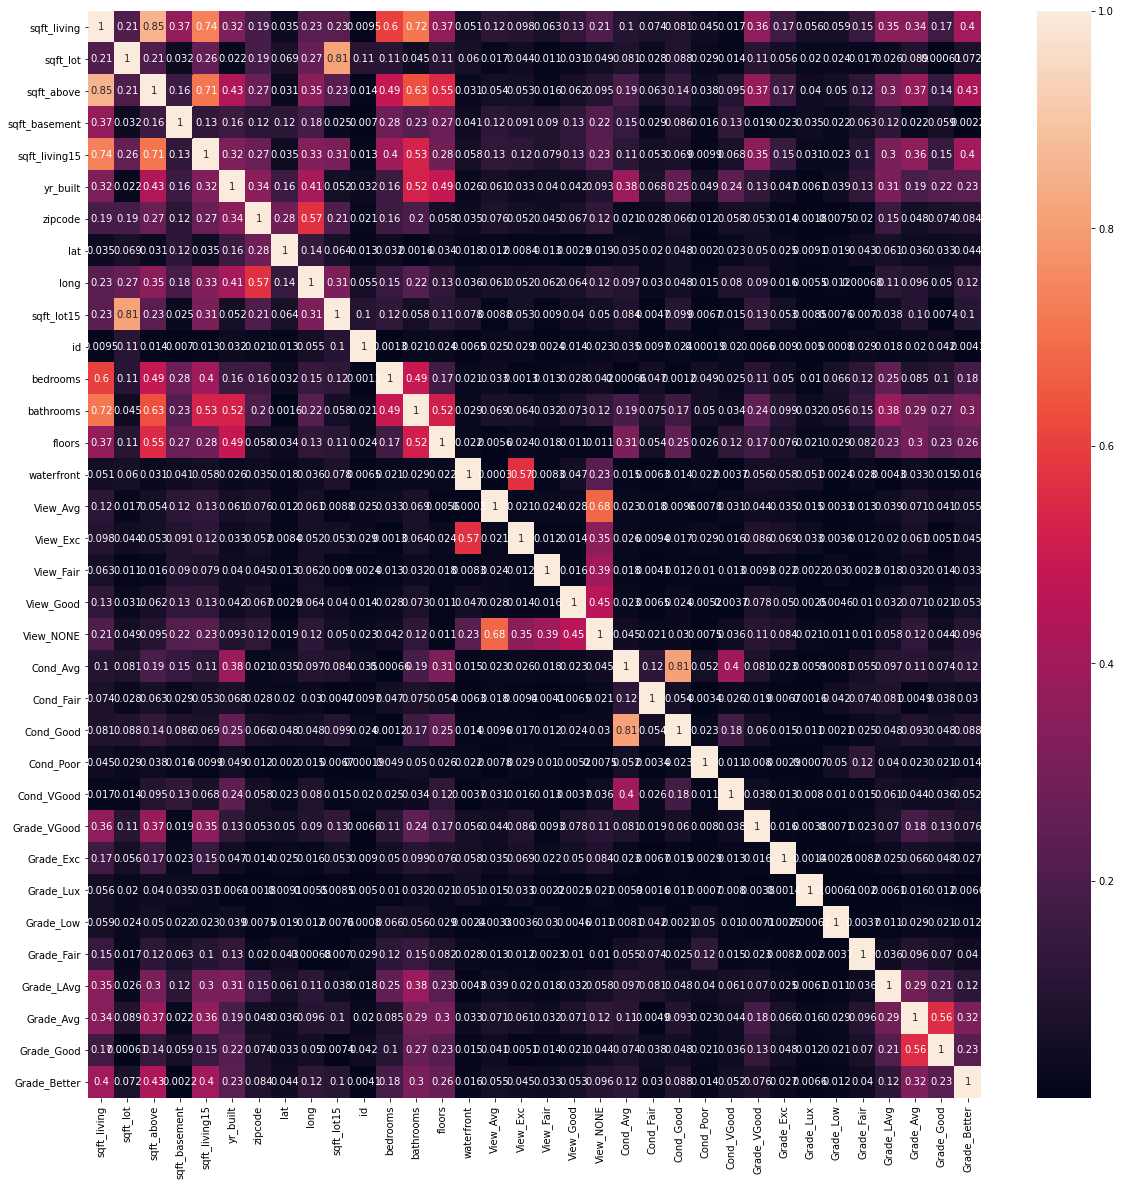

In [35]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(X_train.corr().abs(),annot=True, ax=ax);

Correlations higher than 0.7 are considered to be highly correlated, so let's look at which predictor features are highly correlated with each other.

In [36]:
corr_mtx = abs(X_train.corr())
filtered_corr_mtx = corr_mtx.stack().drop_duplicates()
filtered_corr_mtx[(filtered_corr_mtx.values>=0.7) & (filtered_corr_mtx.values<1)]

sqft_living  sqft_above       0.852181
             sqft_living15    0.737596
             bathrooms        0.715424
sqft_lot     sqft_lot15       0.814697
sqft_above   sqft_living15    0.711584
Cond_Avg     Cond_Good        0.810044
dtype: float64

### Apply Feature Engineering and Transformations to Test Data 

In [37]:
X_test['sqft_basement'].replace('?','0.0',inplace=True)
X_test['sqft_basement'] = pd.to_numeric(X_test['sqft_basement'], errors = 'coerce')

# Feature Scaling
features_to_scale=['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','yr_built','zipcode','lat','long',
'sqft_lot15']
features_not_to_scale = ['id', 'bedrooms', 'bathrooms','floors', 'waterfront', 'view', 'condition', 'grade']
scale = X_test[features_to_scale]
no_scale = X_test[features_not_to_scale]
X_test_scaled = scalar.transform(scale)
scaled_X_test = pd.DataFrame(data=X_test_scaled, columns=scale.columns, index=scale.index)
X_test = pd.concat([scaled_X_test, no_scale],axis=1)

# Encode waterfront
waterfront_test = X_test[['waterfront']]
encoder_waterfront.fit(waterfront_test)
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_test.flatten()
X_test['waterfront'] = waterfront_encoded_test

# Encode view
view_test = X_test[['view']]
ohe.fit(view_test)
view_encoded_test = ohe.transform(view_test)
view_encoded_test = pd.DataFrame(view_encoded_test, columns=ohe.categories_[0], index=X_test.index)
X_test.drop("view", axis=1, inplace=True)
X_test = pd.concat([X_test, view_encoded_test],axis=1)

# Encode condition
condition_test = X_test[['condition']]
ohe.fit(condition_test)
condition_encoded_test = ohe.transform(condition_test)
condition_encoded_test = pd.DataFrame(condition_encoded_test, columns=ohe.categories_[0],index=X_test.index)
X_test.drop('condition', axis=1, inplace=True)
X_test = pd.concat([X_test, condition_encoded_test], axis=1)

# Encode grade
grade_test = X_test[['grade']]
ohe.fit(grade_test)
grade_encoded_test = ohe.transform(grade_test)
grade_encoded_test = pd.DataFrame(grade_encoded_test, columns=ohe.categories_[0], index=X_test.index)
X_test.drop("grade", axis=1, inplace=True)
X_test = pd.concat([X_test, grade_encoded_test], axis=1)

# Rename columns 
X_test.rename(column_names, axis=1,inplace=True)

## Modeling

Let's start by modeling using all the features. This won't be the final model, however this model will be useful in analyzing the importantance of each independent variable and decide which ones to include in the final model. 

In [38]:
predictors = sm.add_constant(X_train)
modelall = sm.OLS(y_train,predictors).fit()
modelall.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     1079.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:52:38   Log-Likelihood:            -2.0052e+05
No. Observations:               15010   AIC:                         4.011e+05
Df Residuals:                   14978   BIC:                         4.014e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.785e+05   9927.081     48.204      0.000    4.59e+05    4.98e+05
sqft_living    6.399e+04   1.28e+04      4.984      0.000    3.88e+04    8.92e+04
sqft_lot       4674.1692   2181.495      2.143      0.032     398.172    8950.166
sqft_above     1.279e+04    1.2e+04      1.062      0.288   -1.08e+04    3.64e+04
sqft_basement  8378.0372   6688.754      1.253      0.210   -4732.740    2.15e+04
sqft_living15  2.698e+04   2124.076     12.700      0.000    2.28e+04    3.11e+04
yr_built      -6.868e+04   1889.884    -36.343      0.000   -7.24e+04    -6.5e+04
zipcode       -2.138e+04   1637.353    -13.058      0.000   -2.46e+04   -1.82e+04
lat            8.065e+04   1366.562     59.020      0.000     7.8e+04    8.33e+04
long          -1.307e+04   1715.455     -7.620      0.000   -1.64e+04   -9709.147
sqft_lot15    -2.005e+04   2242.850     -8.940      0.000   -2.44e+04   -1.57e+04
id            -1.733e-06    4.4e-07     -3.941      0.000    -2.6e-06   -8.71e-07
bedrooms      -1.518e+04   1942.529     -7.813      0.000    -1.9e+04   -1.14e+04
bathrooms      3.228e+04   3151.458     10.242      0.000    2.61e+04    3.85e+04
floors         3.199e+04   3461.068      9.244      0.000    2.52e+04    3.88e+04
waterfront     3.419e+05   2.19e+04     15.621      0.000    2.99e+05    3.85e+05
View_Avg       5.103e+04   6596.174      7.736      0.000    3.81e+04     6.4e+04
View_Exc       2.428e+05   1.25e+04     19.464      0.000    2.18e+05    2.67e+05
View_Fair      7.286e+04   9589.367      7.598      0.000    5.41e+04    9.17e+04
View_Good      1.406e+05   8568.246     16.414      0.000    1.24e+05    1.57e+05
View_NONE     -2.876e+04   4640.055     -6.198      0.000   -3.79e+04   -1.97e+04
Cond_Avg       9.232e+04   6857.133     13.463      0.000    7.89e+04    1.06e+05
Cond_Fair       7.61e+04   1.32e+04      5.778      0.000    5.03e+04    1.02e+05
Cond_Good      1.188e+05   6926.622     17.149      0.000    1.05e+05    1.32e+05
Cond_Poor      3.894e+04   2.75e+04      1.417      0.157   -1.49e+04    9.28e+04
Cond_VGood     1.524e+05   7633.558     19.963      0.000    1.37e+05    1.67e+05
Grade_VGood     1.61e+05   1.05e+04     15.260      0.000     1.4e+05    1.82e+05
Grade_Exc      3.902e+05   1.76e+04     22.195      0.000    3.56e+05    4.25e+05
Grade_Lux      9.397e+05   6.21e+04     15.135      0.000    8.18e+05    1.06e+06
Grade_Low     -2.697e+05   3.46e+04     -7.791      0.000   -3.38e+05   -2.02e+05
Grade_Fair    -2.645e+05   1.39e+04    -19.051      0.000   -2.92e+05   -2.37e+05
Grade_LAvg      -2.3e+05   9753.580    -23.584      0.000   -2.49e+05   -2.11e+05
Grade_Avg     -1.761e+05   8911.127    -19.763      0.000   -1.94e+05   -1.59e+05
Grade_Good    -1.023e+05   8848.606    -11.566      0.000    -1.2e+05    -8.5e+04
Grade_Better   3.025e+04   9320.437      3.245   

The magnitude of each coefficient above determines how strongly each independent variable influences the target variable `price`. However, this is not the only criteria to select independent variables. The magnitude of correlation between independent and dependent variables is also important. Looking at this model output, the correlation list and the multicollinearity list generated in the `Assumptions of Linear Regression` section, the team decided to use `sqft_living`, `lat`, `Grade_Better`, `Grade_VGood` and `View_NONE` in the final model.

Before we start modeling, let's revert feature scaling so that we can generate interpretable coefficients and get rid of the columns that we won't be using. 

In [39]:
features_to_unscale=['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','yr_built','zipcode','lat','long',
'sqft_lot15']
features_not_to_unscale = ['id', 'bedrooms', 'bathrooms','floors', 'waterfront', 'View_Avg', 'View_Exc', 'View_Fair', 
'View_Good', 'View_NONE', 'Cond_Avg', 'Cond_Fair', 'Cond_Good', 'Cond_Poor', 'Cond_VGood', 'Grade_VGood', 'Grade_Exc', 
'Grade_Lux', 'Grade_Low', 'Grade_Fair', 'Grade_LAvg','Grade_Avg', 'Grade_Good', 'Grade_Better']
unscale = X_train[features_to_unscale]
no_unscale = X_train[features_not_to_unscale]
X_train_unscaled = scalar.inverse_transform(unscale)
unscaled_X_train = pd.DataFrame(data=X_train_unscaled, columns=unscale.columns, index=unscale.index)
X_train = pd.concat([unscaled_X_train, no_unscale],axis=1)

features_to_unscale=['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','yr_built','zipcode','lat','long',
'sqft_lot15']
features_not_to_unscale = ['id', 'bedrooms', 'bathrooms','floors', 'waterfront', 'View_Avg', 'View_Exc', 'View_Fair', 
'View_Good', 'View_NONE', 'Cond_Avg', 'Cond_Fair', 'Cond_Good', 'Cond_Poor', 'Cond_VGood', 'Grade_VGood', 'Grade_Exc', 
'Grade_Lux', 'Grade_Low', 'Grade_Fair', 'Grade_LAvg','Grade_Avg', 'Grade_Good', 'Grade_Better']
unscale = X_test[features_to_unscale]
no_unscale = X_test[features_not_to_unscale]
X_test_unscaled = scalar.inverse_transform(unscale)
unscaled_X_test = pd.DataFrame(data=X_test_unscaled, columns=unscale.columns, index=unscale.index)
X_test = pd.concat([unscaled_X_test, no_unscale],axis=1)

In [40]:
X_train = X_train[['sqft_living','lat','Grade_Better','Grade_VGood','View_NONE']]
X_test = X_test[['sqft_living','lat','Grade_Better','Grade_VGood','View_NONE']]

### Baseline Model

Our baseline model, which is the simplest model that can be generated, is to predict that each house has the price of the average house prices in the training set. Let's calculate this prediction and see what it looks like on a plot  

Text(0.5, 1.0, 'Price vs ft $^2$ living')

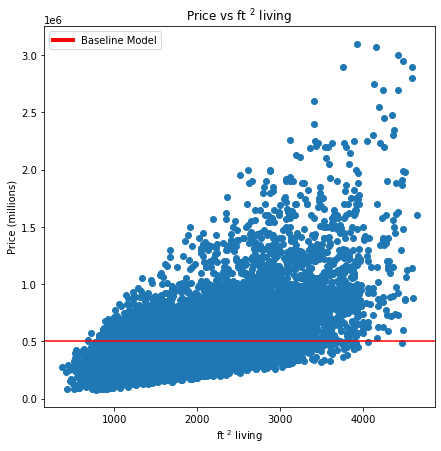

In [41]:
baseline_prediction = np.mean(y_train)
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(X_train['sqft_living'],y_train)
plt.axhline(y=baseline_prediction, color='r', linestyle='-');
ax.set_xlabel('ft $^2$ living')
ax.set_ylabel('Price (millions)')

cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color='red', lw=4)]
ax.legend(custom_lines, ['Baseline Model']);
ax.set_title('Price vs ft $^2$ living')

In [42]:
predictors = np.full(len(y_train), np.mean(y_train))
model1 = sm.OLS(y_train,predictors).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 07 Oct 2021   Prob (F-statistic):                nan
Time:                        00:52:39   Log-Likelihood:            -2.0933e+05
No. Observations:               15010   AIC:                         4.187e+05
Df Residuals:                   15009   BIC:                         4.187e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0000      0.004    222.956      0.000       0.991       1.009
==============================================================================
Omnibus:                     7638.266   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70072.566
Skew:                           2.267   Prob(JB):                         0.00
Kurtosis:                      12.565   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared value is 0, which means that 0% of the variations in dependent variable (`price`)  are explained by the model. This isn't surprising as this is a baseline model.

Let's now calculate the mean-squared error of the training and test set for this baseline model.

In [43]:
train_mse_baseline = mean_squared_error(y_train, np.full(len(y_train), np.mean(y_train)))
test_mse_baseline = mean_squared_error(y_test, np.full(len(y_test), np.mean(y_train)))

print('Baseline Train Mean Squared Error:', train_mse_baseline)
print('Baseline Test Mean Squared Error:', test_mse_baseline)

Baseline Train Mean Squared Error: 76016598023.66982
Baseline Test Mean Squared Error: 122454117916.87492


### Linear Regression Model #1

For the first linear regression model, the team decided to use `sqft_living` as the only independent variable since `sqft_living` has the highest correlation with the target variable, `price`.  

In [44]:
predictors = sm.add_constant(X_train['sqft_living'])
model1 = sm.OLS(y_train,predictors).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     9367.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:52:39   Log-Likelihood:            -2.0569e+05
No. Observations:               15010   AIC:                         4.114e+05
Df Residuals:                   15008   BIC:                         4.114e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.951e+04   4995.430      9.912      0.000    3.97e+04    5.93e+04
sqft_living   230.5006      2.382     96.782      0.000     225.832     235.169
==============================================================================
Omnibus:                     6580.613   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58868.945
Skew:                           1.882   Prob(JB):                         0.00
Kurtosis:                      11.942   Cond. No.                     5.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared value is 0.384, which means that 38.4% of the variations in dependent variable (`price`)  are explained by the independent variable (`sqft_living`). This is a substantial improvement compared to the baseline model. 

The `statsmodel` method above is useful as it provides a nice table to analyze the regression. However, it doesn't allow the extraction of variables, so we will use `sklearn` to extract the intercept and coefficient. 

In [45]:
linreg_modelone = LinearRegression()
linreg_modelone.fit(X_train[['sqft_living']], y_train)
coef_m1 = linreg_modelone.coef_
intercept_m1 = linreg_modelone.intercept_

Now that we have the coefficients and intercept, we can look at a plot which compares the baseline model to this model. 

Text(0.5, 1.0, 'Price vs ft $^2$ living')

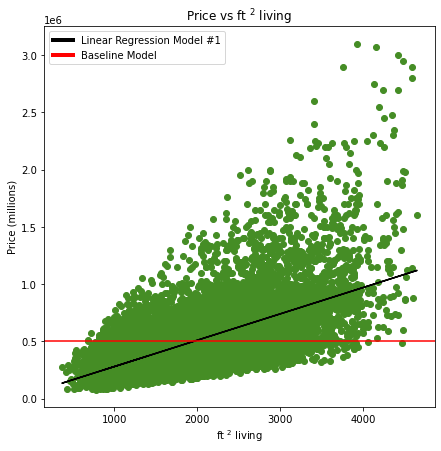

In [46]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(X_train[['sqft_living']], y_train, color='#458D25')
ax.plot(X_train[['sqft_living']], intercept_m1 + coef_m1 * X_train[['sqft_living']], color='black')
plt.axhline(y=baseline_prediction,color='r', linestyle='-');
ax.set_xlabel('ft $^2$ living')
ax.set_ylabel('Price (millions)');

cmap = plt.cm.coolwarm
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', lw=4),
                Line2D([0], [0], color='red', lw=4)]

ax.legend(custom_lines, ['Linear Regression Model #1', 'Baseline Model']);
ax.set_title('Price vs ft $^2$ living')

Let's now calculate the mean-squared error of the training and test set for this model.

In [47]:
y_hat_train_modelone = linreg_modelone.predict(X_train[['sqft_living']])
y_hat_test_modelone = linreg_modelone.predict(X_test[['sqft_living']])

train_mse_modelone = mean_squared_error(y_train, y_hat_train_modelone)
test_mse_modelone = mean_squared_error(y_test, y_hat_test_modelone)

print('Linear Regression Model 1 Train Mean Squared Error:', train_mse_modelone)
print('Linear Regression Model 1 Test Mean Squared Error:', test_mse_modelone)

Linear Regression Model 1 Train Mean Squared Error: 46805012314.251434
Linear Regression Model 1 Test Mean Squared Error: 64896178765.668


Finally, let's compare the mean squared errors between this model and the baseline model. 

In [48]:
train_mse_modelone < train_mse_baseline

True

In [49]:
test_mse_modelone < test_mse_baseline

True

It appears that the mean squared error of the training and test set is less in this model, which means this model is better than the baseline model. 

### Final Linear Regression Model

In this final linear regression model, the team decided to use `sqft_living`, `lat`, `Grade_Better`, `Grade_VGood` and `View_NONE` as independent variable for reasons explained earlier.

In [50]:
predictors = sm.add_constant(X_train)
finalmodel = sm.OLS(y_train,predictors).fit()
finalmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     4249.
Date:                Thu, 07 Oct 2021   Prob (F-statistic):               0.00
Time:                        00:52:39   Log-Likelihood:            -2.0271e+05
No. Observations:               15010   AIC:                         4.054e+05
Df Residuals:                   15004   BIC:                         4.055e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.185e+07   4.97e+05    -64.066      0.000   -3.28e+07   -3.09e+07
sqft_living    165.5888      2.385     69.439      0.000     160.915     170.263
lat           6.768e+05   1.04e+04     64.764      0.000    6.56e+05    6.97e+05
Grade_Better  1.207e+05   5098.229     23.669      0.000    1.11e+05    1.31e+05
Grade_VGood   2.437e+05   8014.289     30.412      0.000    2.28e+05    2.59e+05
View_NONE    -2.059e+05   5379.200    -38.280      0.000   -2.16e+05   -1.95e+05
==============================================================================
Omnibus:                     8275.683   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           136407.068
Skew:                           2.293   Prob(JB):                         0.00
Kurtosis:                      17.038   Cond. No.                     7.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared value is 0.586, which means that 58.6% of the variations in dependent variable (`price`)  are explained by the independent variables. This is a substantial improvement compared to the first linear regression model. 

The `statsmodel` method above is useful as it provides a nice table to analyze the regression. However, it doesn't allow the extraction of variables, so we will use `sklearn` to extract the intercept and coefficient. 

In [51]:
linreg_finalmodel = LinearRegression()
linreg_finalmodel.fit(X_train, y_train)
coef_m1 = linreg_finalmodel.coef_
intercept_m1 = linreg_finalmodel.intercept_

Let's now calculate the mean-squared error of the training and test set for this final linear regression model.

In [52]:
y_hat_train_finalmodel = linreg_finalmodel.predict(X_train)
y_hat_test_finalmodel = linreg_finalmodel.predict(X_test)

train_mse_finalmodel = mean_squared_error(y_train, y_hat_train_finalmodel)
test_mse_finalmodel = mean_squared_error(y_test, y_hat_test_finalmodel)

print('Linear Regression Model 1 Train Mean Squared Error:', train_mse_finalmodel)
print('Linear Regression Model 1 Test Mean Squared Error:', test_mse_finalmodel)

Linear Regression Model 1 Train Mean Squared Error: 31464378752.586876
Linear Regression Model 1 Test Mean Squared Error: 50948452216.11465


Finally, let's compare the mean squared errors between this model and the baseline model. 

In [53]:
train_mse_finalmodel < train_mse_modelone

True

In [54]:
test_mse_finalmodel < test_mse_modelone

True

It appears that the mean squared error of the training and test set is less in this final model compared to the first model, which means this model is better than the first model. 